In [1]:
import cu_rsc as cr
cr.setup_tables()
import RSC_sim
import numpy as np
import cupy as cp
import cupyx
import matplotlib.pyplot as plt

M_dev = cr.load_m_table_device()        # upload to GPU
res   = cr.resources_from_config(M_dev)

c:\Users\LyuQi\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Original

In [2]:
def score_sequence(mol):
    """Return (penalized_score, raw_survivors_in_region)."""
    
    n_x, n_y, n_z, is_lost, spin, mN = mol[:, 0], mol[:, 1], mol[:, 2], mol[:, 5], mol[:,4], mol[:,3]
    mask = (is_lost == 0) & (n_x == 0) & (n_y == 0) & (n_z == 0) & (spin == 0) & (mN == 1)
    raw = int(cp.count_nonzero(mask).get())
    return raw

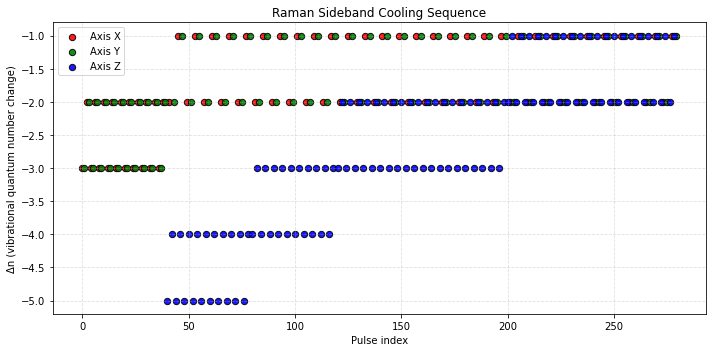

In [3]:
original_gpu = cr.get_original_sequences_gpu()  # list/tuple of cp.ndarray blocks
seq_ori_XY = cp.tile(original_gpu[0], (10, 1))
seq_ori_XYZ1 = cp.tile(original_gpu[1], (5, 1))
seq_ori_XYZ2 = cp.tile(original_gpu[2], (5, 1))
seq_ori_XYZ3 = cp.tile(original_gpu[3], (10, 1))
seq_ori_XYZ4 = cp.tile(original_gpu[4], (10, 1))


# Repeat each block along the first axis, then concatenate in order
blocks = [
    seq_ori_XY,  
    seq_ori_XYZ1,  
    seq_ori_XYZ2,  
    seq_ori_XYZ3,  
    seq_ori_XYZ4,  
]

seq_gpu = cp.concatenate(blocks, axis=0)
cr.visualize_sequence(seq_gpu)

Raman pulses: 100%|██████████| 280/280 [00:46<00:00,  6.07it/s]


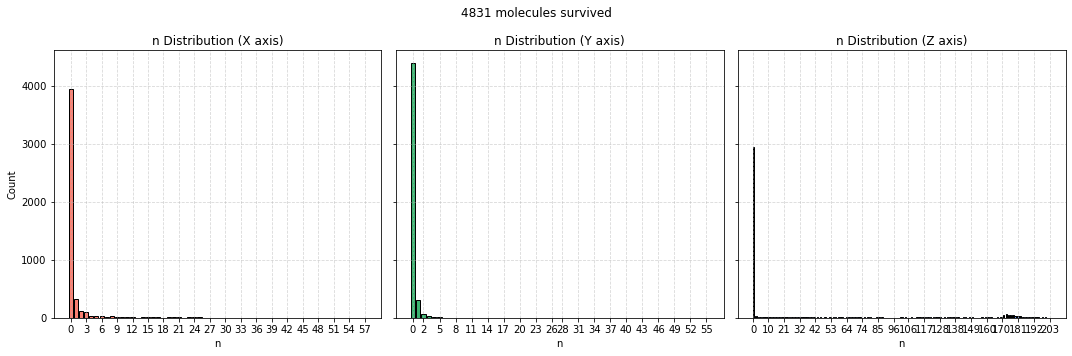

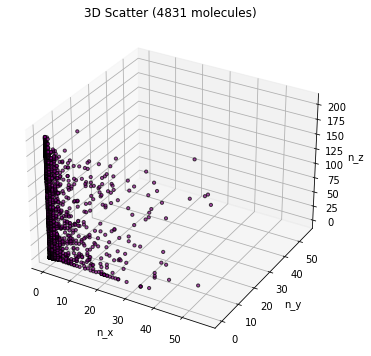

survival_rate_mean 0.4831
mot_mean [ 1.14572552  0.23411302 43.95942869]
mot_sem [0.00198431 0.00081536 0.03142711]


In [5]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, seq_gpu, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [6]:
score_sequence(mol_0)

2806

#### Optimized, segmental

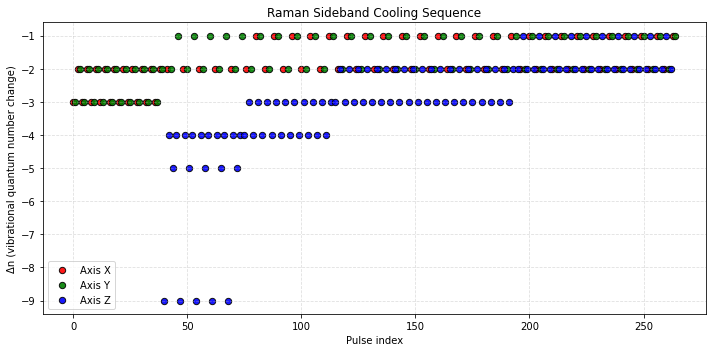

In [13]:
op_seq = np.load("ga_runs/SEGIDX_20251108_213339/final_top5/top1_sequence.npy")
cr.visualize_sequence(op_seq)

Raman pulses: 100%|██████████| 265/265 [00:45<00:00,  5.87it/s]


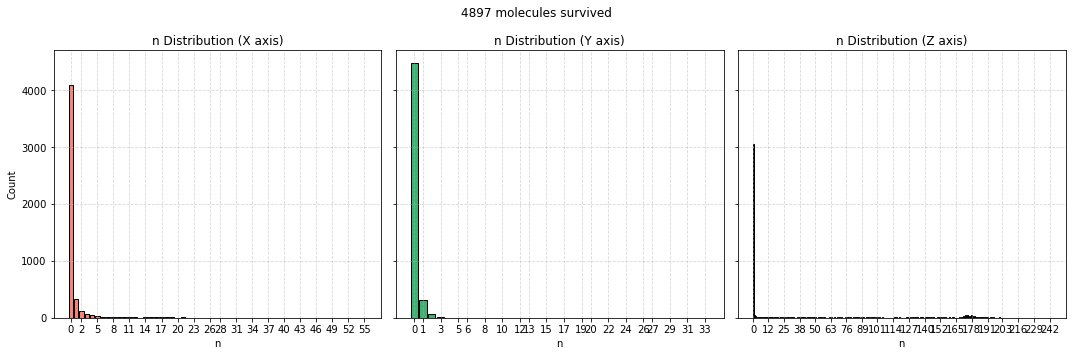

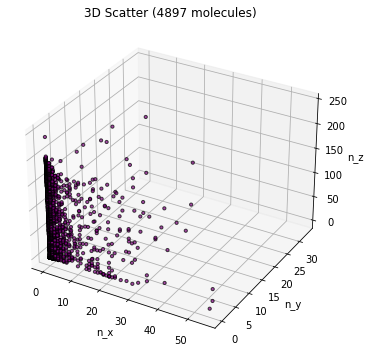

survival_rate_mean 0.4897
mot_mean [ 0.93955483  0.19236267 38.72350419]
mot_sem [0.0017501  0.00064525 0.02888224]


In [14]:
temp = [25e-6, 25e-6, 25e-6]
mol_0 = cr.build_thermal_molecules_gpu(10_000, temp)
cr.raman_cool_with_pumping(mol_0, op_seq, res, show_progress=True)
dist_gpu = cr.get_n_distribution_gpu(mol_0, max_bins=20)

result = cr.bootstrap_stats_from_molecules(mol_0)
print("survival_rate_mean", result['survival_rate_mean'])
print("mot_mean", result['mot_mean'])
print("mot_sem", result['mot_sem'])

In [15]:
score_sequence(mol_0)

2944